# Seleção e pré-processamento de dados:

* **Base de dados**: ["Loan Data Set"](https://www.kaggle.com/datasets/mirzahasnine/loan-data-set?resource=download);
* **Problema a ser investigado**: Aprovação ou não aprovação de empréstimo para pessoas de acordo com seus dados;
* **Número de amostras**: 614;
* **Número de atributos**: 12;
* **Tipos de atributos**: Categóricos e numéricos;
* **Valores ausentes**: Sim.

In [137]:
#Bibliotecas:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist 
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
import matplotlib.pyplot as plt

### Limpeza de dados

* Leitura da base de dados

In [128]:
def ShowInformationDataFrame(df, message=""):
    print(message+"\n")
    # Imprime as 10 primeiras linhas do arquivo
    print("PRIMEIRAS 10 LINHAS\n")
    print(df.head(10))
    print("\n")
    # Imprime informações sobre os dados
    print("INFORMAÇÕES GERAIS DOS DADOS\n")
    print(df.info())
    print("\n")
    # Imprime uma analise descritiva sobre os dados
    print("DESCRIÇÃO DOS DADOS\n")
    print(df.describe())
    print("\n")
    # Imprime a quantidade de valores faltantes por coluna
    print("VALORES FALTANTES\n")
    print(df.isnull().sum())
    print("\n") 

In [129]:
input_file = './0-Datasets/loan_train.csv'
names = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Term','Credit_History', 'Area', 'Status']
columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Term','Credit_History', 'Area', 'Status']
features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Term','Credit_History', 'Area']
# columns = ['Self_Employed', 'Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Term','Credit_History', 'Status']
# features = ['Self_Employed', 'Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Term','Credit_History']
target = 'Status'
df = pd.read_csv(input_file,        # Nome do arquivo com dados
                names = names,      # Nome das colunas 
                usecols = columns, # Define as colunas que serão  utilizadas
                na_values='')       # Define que ? será considerado valores ausentes

ShowInformationDataFrame(df, "DataFrame")

DataFrame

PRIMEIRAS 10 LINHAS

  Gender Married Dependents     Education Self_Employed  Applicant_Income  \
0   Male      No          0  Not Graduate            No            604500   
1   Male      No          0      Graduate            No            584900   
2   Male     Yes          1      Graduate            No            458300   
3   Male     Yes          0      Graduate           Yes            300000   
4   Male     Yes          0  Not Graduate            No            258300   
5   Male      No          0      Graduate            No            600000   
6   Male     Yes          2      Graduate           Yes            541700   
7   Male     Yes          0  Not Graduate            No            233300   
8   Male     Yes         3+      Graduate            No            303600   
9   Male     Yes          2      Graduate            No            400600   

   Coapplicant_Income  Loan_Amount   Term  Credit_History       Area Status  
0                 0.0     11500000  360.0 

* Tratamento dos valores faltantes
  * método de DELETAR os objetos que possuem valores faltantes

In [130]:
def UpdateMissingValues(df, column, method="mode", number=0):
    if method == 'number':
        # Substituindo valores ausentes por um número
        df[column].fillna(number, inplace=True)
    elif method == 'median':
        # Substituindo valores ausentes pela mediana 
        median = df[column].median()
        df[column].fillna(median, inplace=True)
    elif method == 'mean':
        # Substituindo valores ausentes pela média
        mean = df[column].mean()
        df[column].fillna(mean, inplace=True)
    elif method == 'mode':
        # Substituindo valores ausentes pela moda
        mode = df[column].mode()[0]
        df[column].fillna(mode, inplace=True)
    elif method == 'delete':
        df.dropna(axis=0, how='any', subset=column, inplace=True)

columns_missing_value = df.columns[df.isnull().any()]
print(columns_missing_value)
method = 'delete' # number or median or mean or mode
    
for c in columns_missing_value:
    UpdateMissingValues(df, c, method)
    
ShowInformationDataFrame(df,"Dataframe UpdateMissingValues")

Index(['Gender', 'Married', 'Dependents', 'Self_Employed', 'Term',
       'Credit_History'],
      dtype='object')
Dataframe UpdateMissingValues

PRIMEIRAS 10 LINHAS

  Gender Married Dependents     Education Self_Employed  Applicant_Income  \
0   Male      No          0  Not Graduate            No            604500   
1   Male      No          0      Graduate            No            584900   
2   Male     Yes          1      Graduate            No            458300   
3   Male     Yes          0      Graduate           Yes            300000   
4   Male     Yes          0  Not Graduate            No            258300   
5   Male      No          0      Graduate            No            600000   
6   Male     Yes          2      Graduate           Yes            541700   
7   Male     Yes          0  Not Graduate            No            233300   
8   Male     Yes         3+      Graduate            No            303600   
9   Male     Yes          2      Graduate            No        

* Conversão dos atributos categóricos para numéricos

In [131]:
# Converte os atributos categóricos para numéricos
    # get all categorical columns
cat_columns = df.select_dtypes(['object']).columns

    # convert all categorical columns to numeric
df[cat_columns] = df[cat_columns].apply(lambda x: pd.factorize(x)[0])

ShowInformationDataFrame(df,"Dataframe numérico")

Dataframe numérico

PRIMEIRAS 10 LINHAS

   Gender  Married  Dependents  Education  Self_Employed  Applicant_Income  \
0       0        0           0          0              0            604500   
1       0        0           0          1              0            584900   
2       0        1           1          1              0            458300   
3       0        1           0          1              1            300000   
4       0        1           0          0              0            258300   
5       0        0           0          1              0            600000   
6       0        1           2          1              1            541700   
7       0        1           0          0              0            233300   
8       0        1           3          1              0            303600   
9       0        1           2          1              0            400600   

   Coapplicant_Income  Loan_Amount   Term  Credit_History  Area  Status  
0                 0.0     

### Balanceamento de dados

A base se apresentou desbalanceada, dessa forma, foi necessário utilizar uma técnica de balanceamento.

* Técnicas de Oversample:
  * SMOTE (utilizada)
  * ADASYN

Base default
 1    341
0    158
Name: Status, dtype: int64
Base balanceada
 0    341
1    341
Name: Status, dtype: int64


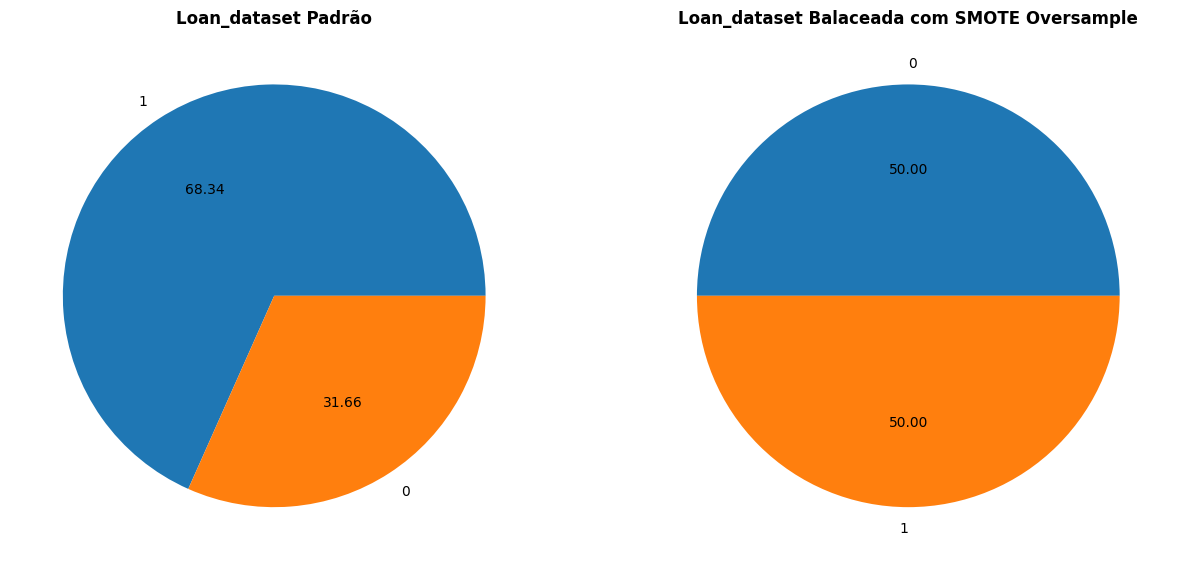

In [132]:
x = df.drop(['Status'], axis=1)
y = df['Status']

# Synthetic Minority Oversampling Technique (SMOTE)
x_os, y_os = SMOTE().fit_resample(x, y)
# Adaptive Synthetic (ADASYN) sampling method
# x_os, y_os = ADASYN().fit_resample(x, y)

print('Base default\n',y.value_counts())
print('Base balanceada\n',y_os.value_counts())

fig, ax = plt.subplots(1, 2, figsize=(15, 10))

y.value_counts().plot.pie(ax=ax[0], autopct='%.2f')
y_os.value_counts().plot.pie(ax=ax[1], autopct='%.2f')

plt.subplots_adjust(hspace = 1)

for n in np.arange(0,2):
    ax[n].set_ylabel('')
    
ax[0].set_title('Loan_dataset Padrão', fontweight='bold')
ax[1].set_title('Loan_dataset Balaceada com SMOTE Oversample', fontweight='bold')

plt.show()

---
# Normalização e redução de dados

### Normalização de dados
* Max-Min
* Z-Score

In [133]:
# Z-score normalization
x_zcore = StandardScaler().fit_transform(x_os)
normalized1Df = pd.DataFrame(data = x_zcore, columns = features)
normalized1Df = pd.concat([normalized1Df, y_os], axis = 1)
ShowInformationDataFrame(normalized1Df,"Dataframe Z-Score Normalized")

# Mix-Max normalization
x_minmax = MinMaxScaler().fit_transform(x_os)
normalized2Df = pd.DataFrame(data = x_minmax, columns = features)
normalized2Df = pd.concat([normalized2Df, y_os], axis = 1)
ShowInformationDataFrame(normalized2Df,"Dataframe Min-Max Normalized")

Dataframe Z-Score Normalized

PRIMEIRAS 10 LINHAS

    Gender   Married  Dependents  Education  Self_Employed  Applicant_Income  \
0 -0.39983 -1.155689   -0.731570  -1.689114      -0.340886          0.121421   
1 -0.39983 -1.155689   -0.731570   0.592026      -0.340886          0.087530   
2 -0.39983  0.865285    0.323252   0.592026      -0.340886         -0.131383   
3 -0.39983  0.865285   -0.731570   0.592026       2.933536         -0.405110   
4 -0.39983  0.865285   -0.731570  -1.689114      -0.340886         -0.477216   
5 -0.39983 -1.155689   -0.731570   0.592026      -0.340886          0.113640   
6 -0.39983  0.865285    1.378074   0.592026       2.933536          0.012830   
7 -0.39983  0.865285   -0.731570  -1.689114      -0.340886         -0.520445   
8 -0.39983  0.865285    2.432895   0.592026      -0.340886         -0.398885   
9 -0.39983  0.865285    1.378074   0.592026      -0.340886         -0.231156   

   Coapplicant_Income  Loan_Amount      Term  Credit_History      Ar

### Redução de dados (PCA)

Explained variance per component:
[0.2528184619259383, 0.193175125793418, 0.14082125927937708, 0.13036654581964416, 0.09045133316216696, 0.08163358370657052, 0.06835679905435423, 0.018840341384534647, 0.01570079977710397, 0.005146466908215773, 0.0026892831886764054]



Dataframe PCA

PRIMEIRAS 10 LINHAS

   principal component 1  principal component 2  Status
0               0.666775               1.051223       0
1               0.533621              -0.235533       1
2              -0.461120               0.008707       0
3              -0.411787              -0.309591       1
4              -0.322984               0.562534       1
5               0.534233              -0.234903       1
6              -0.644849              -0.297027       1
7              -0.320802               0.564581       1
8              -0.637944              -0.190896       0
9              -0.586976              -0.215572       1


INFORMAÇÕES GERAIS DOS DADOS

<class 'pandas.core.frame.DataFrame'>
RangeInd

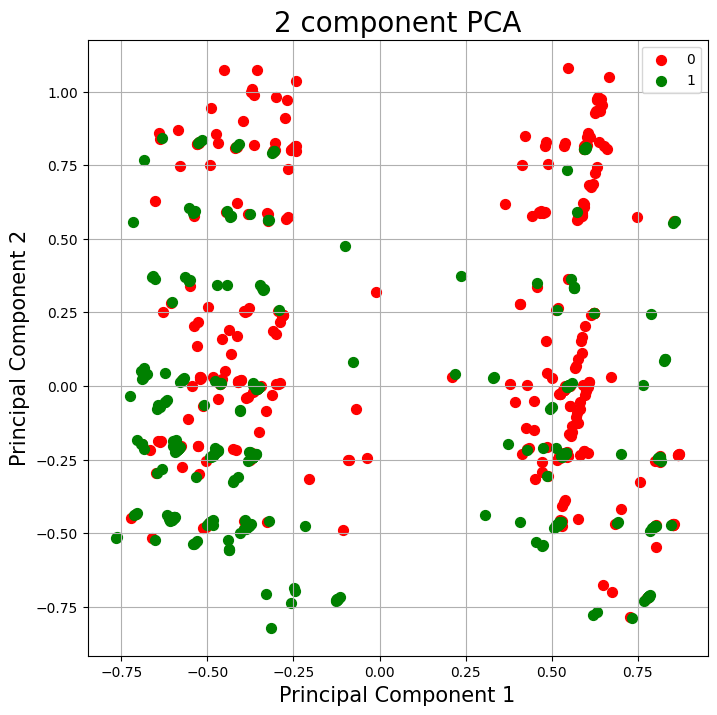

In [134]:
def VisualizePcaProjection(finalDf, targetColumn):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)

    ax.set_title('2 component PCA', fontsize = 20)
    targets = [ 0, 1 ]
    colors = ['r', 'g']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf[targetColumn] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'],
                   finalDf.loc[indicesToKeep, 'principal component 2'],
                   c = color, s = 50)
    ax.legend(targets)
    ax.grid()
    plt.show()

# PCA projection
pca = PCA()
# utilizando a normalização Z-Score    
# principalComponents = pca.fit_transform(x_zcore)
# utilizando a normalização Max-Min  
principalComponents = pca.fit_transform(x_minmax)
print("Explained variance per component:")
print(pca.explained_variance_ratio_.tolist())
print("\n\n")

principalDf = pd.DataFrame(data = principalComponents[:,0:2], 
                            columns = ['principal component 1', 
                                        'principal component 2'])
finalDf = pd.concat([principalDf, y_os], axis = 1)    
ShowInformationDataFrame(finalDf,"Dataframe PCA")

VisualizePcaProjection(finalDf, target)

---
# Análise descritiva de dados
* Distribuição de frequência
* Visualização de dados (Histograma, Gráfico de setores, dispersão, etc)
* Medidas de resumo
  * Medidas de tendência central
  * Medidas de dispersão
  * Medidas de posição relativa
  * Medidas de associação

---
# Análise de grupos

In [ ]:
def plot_samples(projected, labels, title):    
    fig = plt.figure()
    u_labels = np.unique(labels)
    for i in u_labels:
        plt.scatter(projected[labels == i , 0] , projected[labels == i , 1] , label = i,
                    edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('tab10', 10))
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.legend()
    plt.title(title)
    plt.show()

### K-means
* Variar número de grupos (parâmetro k)

c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


575.1938345128333
For n_clusters = 2, silhouette score is 0.2536167935861819)
For n_clusters = 2, homogeinity score is 0.03693033119247111)


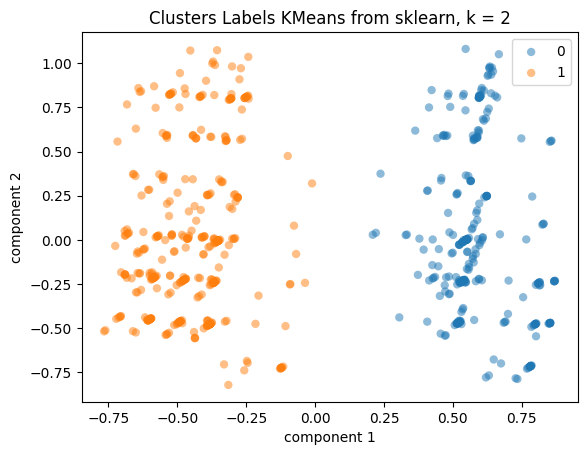

c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


486.4549982122049
For n_clusters = 3, silhouette score is 0.2691023490620424)
For n_clusters = 3, homogeinity score is 0.05304736911755601)


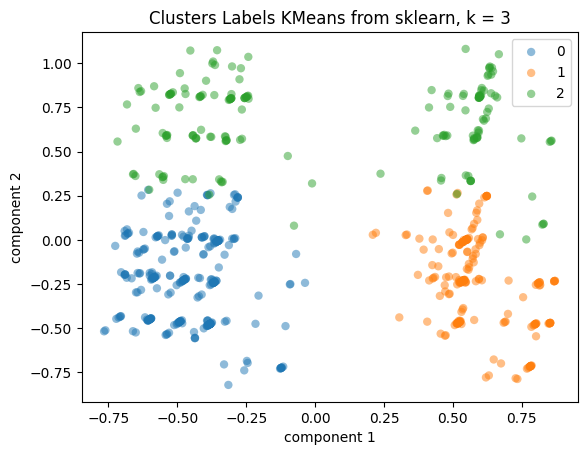

c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


433.7718251747848
For n_clusters = 4, silhouette score is 0.27077091721263824)
For n_clusters = 4, homogeinity score is 0.061245997768024335)


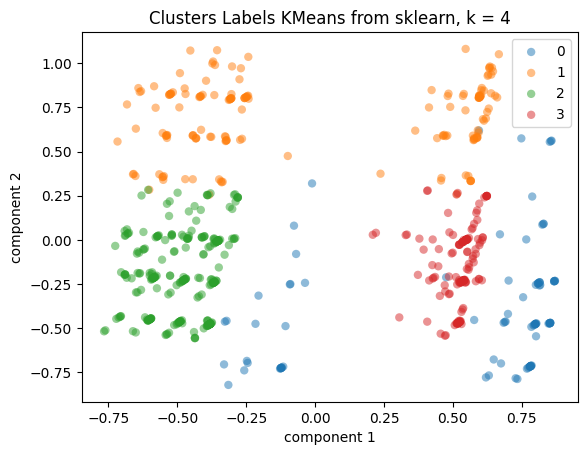

c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


392.420276328381
For n_clusters = 5, silhouette score is 0.28213149876024596)
For n_clusters = 5, homogeinity score is 0.18556557057501194)


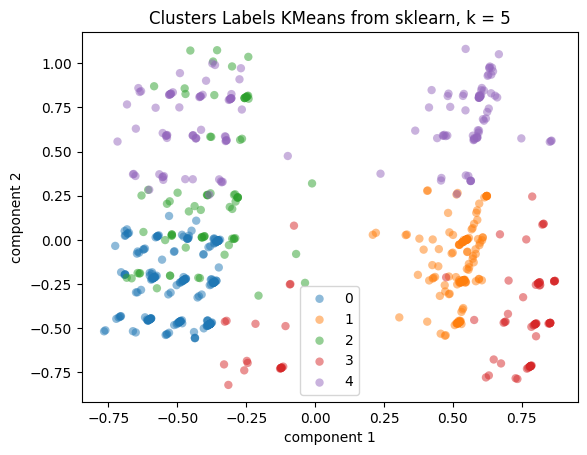

In [146]:
#Applying sklearn kmeans function
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k).fit(principalComponents)
    print(kmeans.inertia_)
    centers = kmeans.cluster_centers_
    score = silhouette_score(principalComponents, kmeans.labels_)    
    print("For n_clusters = {}, silhouette score is {})".format(k, score))
    homogeneity = homogeneity_score(y_os.to_numpy(), kmeans.labels_)
    print("For n_clusters = {}, homogeinity score is {})".format(k, homogeneity))

    #Visualize the results sklearn
    plot_samples(principalComponents, kmeans.labels_, f'Clusters Labels KMeans from sklearn, k = {k}')

### GMM

[0.57184751 0.42815249]
[[-4.43412473e-01 -2.76533857e-03  2.05677255e-03  1.55216394e-02
   2.45635386e-02 -4.61480879e-02 -3.69969185e-02 -2.38711597e-04
  -7.45768261e-04 -1.34122841e-04  2.06161748e-05]
 [ 5.92228988e-01  3.69343165e-03 -2.74705922e-03 -2.07309567e-02
  -3.28074659e-02  6.16361448e-02  4.94136925e-02  3.18827133e-04
   9.96060348e-04  1.79136671e-04 -2.75353019e-05]]
For k = 2
Silhouette score is 0.2536167935861819
Homogeinity score is 0.03693033119247111


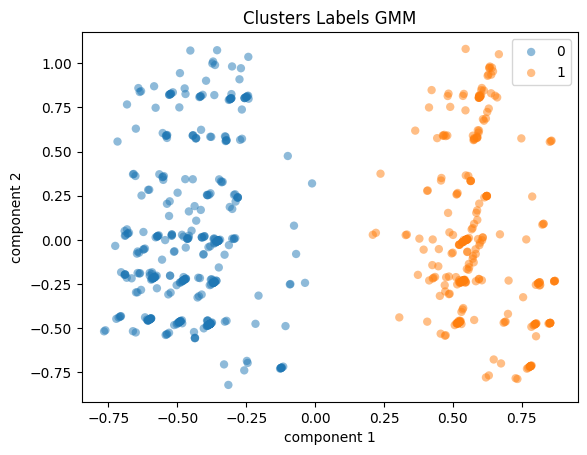

[0.06786971 0.53948616 0.39264413]
[[ 2.31081236e-01 -3.03264411e-01  1.62213403e-01  1.09084586e-01
   5.57512205e-01  7.12383576e-02 -1.63721251e-01  2.61478769e-02
  -1.76396769e-02 -1.81575181e-02  1.35439218e-02]
 [-4.61218603e-01  2.29509638e-02 -1.00846713e-02  4.77743105e-03
  -1.30584991e-02 -1.83758955e-02 -3.04024333e-02 -4.29973643e-03
  -1.21719642e-03 -3.12303421e-04  3.20460956e-04]
 [ 5.93763205e-01  2.08859342e-02 -1.41829079e-02 -2.54197022e-02
  -7.84254959e-02  1.29343964e-02  7.00721169e-02  1.38802417e-03
   4.72147726e-03  3.56768051e-03 -2.78141496e-03]]
For k = 3
Silhouette score is 0.23233816713552252
Homogeinity score is 0.04213494271288042


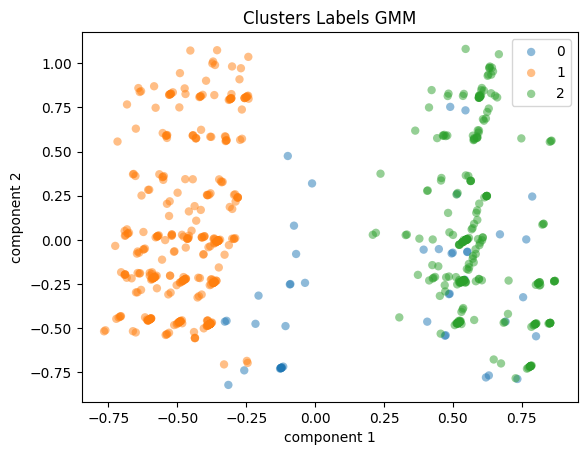

[0.11876833 0.30938416 0.14076246 0.43108504]
[[ 5.93081082e-01  6.49244230e-01  3.48536127e-01  2.04498537e-03
  -8.38518706e-03  8.90805319e-02  2.72321919e-02  9.87291248e-03
   6.50370624e-03 -5.14946597e-03  1.78832964e-03]
 [ 5.91901881e-01 -2.44124647e-01 -1.37599846e-01 -2.94743278e-02
  -4.21828431e-02  5.11006218e-02  5.79288657e-02 -3.34885492e-03
  -1.11824921e-03  2.22471399e-03 -7.24620894e-04]
 [-4.12231338e-01  6.77515994e-01  3.31723968e-01  1.23537955e-01
   7.76067109e-02 -9.13987217e-02 -4.95023063e-02  5.68713593e-03
  -5.01153458e-03  4.47936638e-03 -1.31305663e-03]
 [-4.53594068e-01 -2.24898019e-01 -1.05589659e-01 -1.97489944e-02
   7.24331905e-03 -3.13723707e-02 -3.29135265e-02 -2.17368222e-03
   6.47135027e-04 -1.64056830e-03  4.56101174e-04]]
For k = 4
Silhouette score is 0.2837944875479029
Homogeinity score is 0.05800585478045419


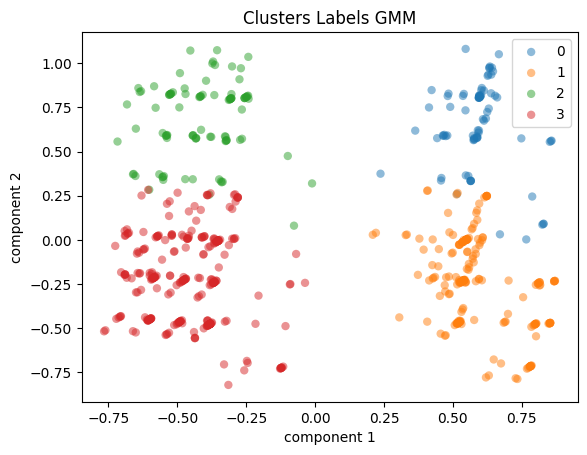

[0.13782991 0.13636364 0.09318503 0.32697947 0.30564195]
[[ 5.28491813e-01 -3.86762540e-01  1.76504992e-01  1.49853176e-01
   5.37978393e-01 -3.41342099e-01  6.01411515e-02  3.73853717e-03
   4.41166464e-03  1.01406526e-03  2.40756615e-04]
 [-4.23516119e-01  6.89963666e-01  3.22869371e-01  1.14536725e-01
   5.38640510e-02 -7.96852649e-02 -3.95474444e-02  2.60003642e-03
  -4.75484213e-03  3.77724399e-03 -1.41893534e-03]
 [-4.48905399e-01  2.00320166e-03 -5.22122431e-01  3.95571054e-01
   1.71863068e-02  1.51469216e-02 -1.76523794e-02  1.93325410e-02
   1.67871226e-03 -2.42326974e-03  3.50220917e-02]
 [ 5.34627144e-01  1.15853776e-01 -5.19543808e-02 -6.76823285e-02
  -1.98531097e-01  1.67313173e-01  2.76654208e-02  3.76333930e-03
   2.73957467e-03  4.39286550e-04 -6.52186683e-04]
 [-4.84457780e-01 -2.57971733e-01 -8.87737249e-03 -1.66873245e-01
  -5.94830841e-02  5.86923577e-03 -3.36913945e-02 -1.27661496e-02
  -3.31069517e-03 -1.87367104e-03 -9.45542781e-03]]
For k = 5
Silhouette score 

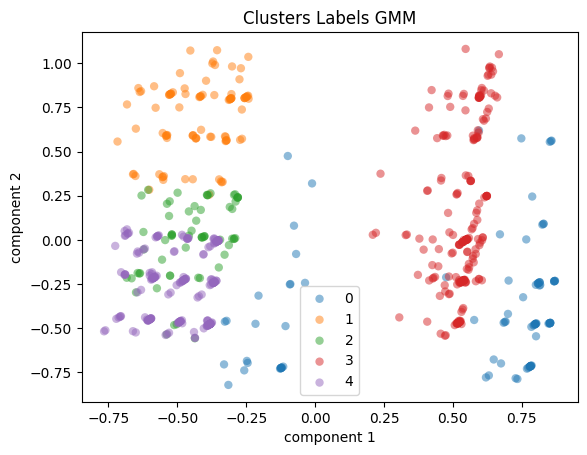

[0.14222861 0.1026393  0.33870872 0.10117302 0.17448789 0.14076246]
[[ 4.97189863e-01 -2.24057625e-01 -6.85558524e-02 -2.95378236e-01
  -2.32977368e-01  1.95592306e-01  2.22402273e-02  1.93663224e-02
   2.85660887e-03  2.26204964e-02  6.56315318e-03]
 [ 5.63211795e-01  7.02447292e-01  2.99342705e-01 -1.25710081e-02
  -1.18543489e-01  1.33001916e-01  1.65553741e-02  4.69825345e-03
   1.09409353e-02 -3.89529364e-03 -1.22733694e-03]
 [-4.60379159e-01 -2.90189777e-01  1.79754954e-02 -1.42785826e-01
  -7.62724934e-03 -3.66031330e-02 -3.48960592e-02 -7.59050585e-03
   3.43904540e-04 -1.40374811e-03 -7.26388191e-03]
 [ 7.78391469e-01 -3.58795798e-01  1.56285299e-01  1.31010434e-01
   5.02792096e-01 -2.79899757e-01  1.19701585e-01 -1.08134368e-02
  -4.63877578e-03 -6.61637575e-04  1.99126554e-03]
 [ 3.83214631e-02 -5.78750221e-03 -5.13321104e-01  3.49709608e-01
  -7.96985004e-02  6.94120843e-02  1.03999569e-02 -2.13314089e-03
  -2.69927024e-03 -1.66521392e-02  9.37722211e-03]
 [-4.12231338e-01

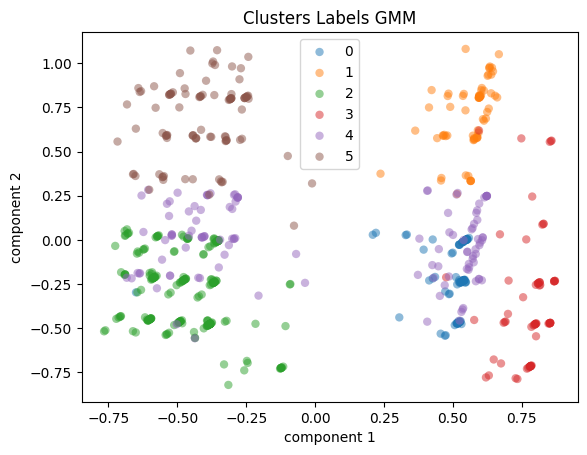

[0.2239273  0.32697947 0.09237536 0.1147789  0.0498532  0.09237884
 0.09970693]
[[-4.84613735e-01 -1.77722389e-01 -1.17424633e-01 -2.68878178e-01
   3.34958562e-02  3.68181699e-02 -4.66523300e-02 -1.38629009e-02
   2.53473449e-03 -2.85477422e-03  2.67796460e-04]
 [ 5.34627144e-01  1.15853776e-01 -5.19543808e-02 -6.76823285e-02
  -1.98531097e-01  1.67313173e-01  2.76654208e-02  3.76333930e-03
   2.73957467e-03  4.39286550e-04 -6.52186683e-04]
 [-4.56465070e-01  6.02366679e-01  4.95505921e-01 -9.39819816e-02
   9.04314577e-02 -5.62768906e-02  2.27405031e-02  3.61654228e-03
  -9.18189743e-03  9.33989466e-04 -6.43467702e-04]
 [-4.27363461e-01 -5.03840202e-01  2.82167538e-01  1.03031151e-01
  -1.22060386e-01 -1.41900166e-01 -2.24262703e-02  1.55772049e-03
  -6.39279165e-03  4.77489007e-03 -1.01354653e-02]
 [-3.00659924e-01  8.15054309e-01  2.32009533e-02  5.48756874e-01
   7.24359770e-02 -1.59440643e-01 -1.56049670e-01  5.75681497e-03
  -1.12042785e-03  1.15261001e-02 -1.87658218e-03]
 [-4.

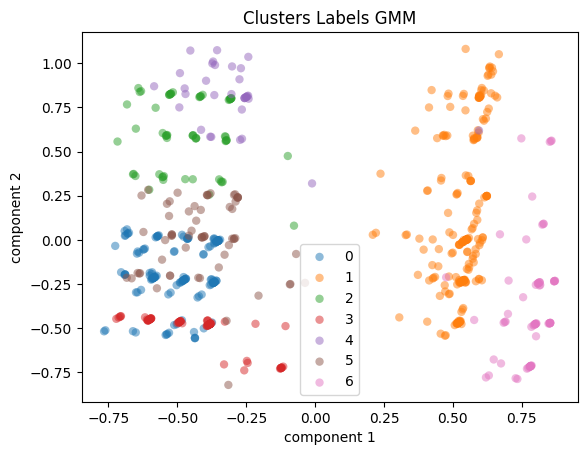

In [145]:
for k in range(2, 8):
    #Applying sklearn GMM function
    gm  = GaussianMixture(n_components=k).fit(principalComponents)
    print(gm.weights_)
    print(gm.means_)
    gm_predicts = gm.predict(principalComponents)
    silhouette_gm_score = silhouette_score(principalComponents, gm_predicts)
    homogeneity_gm_score = homogeneity_score(y_os.to_numpy(), gm_predicts)
    print("For k =", k)
    print("Silhouette score is {}".format(silhouette_gm_score))
    homogeneity = homogeneity_score(y_os.to_numpy(), kmeans.labels_)
    print("Homogeinity score is {}".format(homogeneity_gm_score))
    #Visualize the results sklearn
    plot_samples(principalComponents, gm_predicts, 'Clusters Labels GMM')

---
# Classificação
* Divisão da base:
  * Holdout (Treinamento 70% e Teste 30%)
  * Cross-Validation (k=10)
* Métricas:
  * Matrix de confusão
  * Acurácia
  * F1 Score

### Árvore de Decisão (Decision Tree)

### KNN (K-Mearest Neighbors)
* Encontrar o parâmetro k com melhor resultado

### SVM (Support Vectors Machine)

### Rede Neural MLP (Multilayer Perceptron)
* Arquitetura da rede:
  * Número de neurônios
  * Camadas escondidas
  * Tipo de função de ativação

### Comparação final dos classificadores